In [2]:
import numpy as np
from generator import generate_true_calibration_map, generate_binary_label_sequence
from general_methods import isocal, logcal, betacal, sva
from modified_methods import isobins_cp, rcir_cp
from new_methods import htlb_cp, htlb_maxcp
from utils import make_monotonic
from matplotlib import pyplot as plt
%matplotlib inline

## Generating a true calibration map and estimating regular or cautious calibration maps with all used methods

Load the necessary precalculated data for the HLTB+MAXCP method

In [23]:
lb_map_fixed_perc_100_2000 = np.load("../data/fixed_bound_map_100_2000.npy", allow_pickle=True).item()
lb_map_max = np.load("../data/combined_max_statistic_lower_bound_map_100_2000_M10000_07_09_500.npy", allow_pickle=True).item()["lb_q"]

Generate a true calibration map of size 10000, with probabilities ranging from 0.7 to 1 (`true_cal_map`).

Then from that true map generate a binary label set of the same size, each label drawn from the underlying true probability in true_cal_map (`calibration_set_labels`). This represents the true labels of one calibration set.

We create a corresponding score vector that has placeholder scores for the calibration set labels (scores that our imaginary black box model predicted for our calibration set instances). As we assume monotonicity between true calibrated values and this score vector, so the absolute values in this `generated_scores` are not important. Some methods need them for calculation, but as our `calibration_set_labels` are already ordered, it doesn't really influence anything.

In [4]:
N = 10000
subsequence_length = 1000
true_cal_seed = 5
cal_set_seed = 11

true_cal_map = generate_true_calibration_map(N, true_cal_seed, lowest_prob=0.7, highest_prob=1)
calibration_set_labels = generate_binary_label_sequence(true_cal_map, cal_set_seed)
generated_scores = np.sort(np.random.rand(N))

We calculate the regular or cautious calibration maps using the our ordered calibration set labels. We also save the monotonic versions as is mentioned in the article.

In [18]:
conf = 0.99

calibration_maps = {}
monotonic_calibration_maps = {}

calibration_maps['true'] = true_cal_map
calibration_maps['isocal'] = isocal(generated_scores, calibration_set_labels)
calibration_maps['logcal'] = logcal(generated_scores, calibration_set_labels)
calibration_maps['betacal'] = betacal(generated_scores, calibration_set_labels)
calibration_maps['sva'] = sva(generated_scores, calibration_set_labels)
calibration_maps['isobins_cp'] = isobins_cp(calibration_set_labels, conf=conf)
calibration_maps['rcir_cp'] = rcir_cp(generated_scores, calibration_set_labels, credible_level=conf)
calibration_maps['htlb_cp'] = htlb_cp(calibration_set_labels, subsequence_length=subsequence_length, confidence=conf)
calibration_maps['htlb_maxcp'] = htlb_maxcp(calibration_set_labels, lb_map_fixed_perc_100_2000, lb_map_max, window_size=2000, w_min=100)

monotonic_calibration_maps['isobins_cp'] = make_monotonic(calibration_maps['isobins_cp'])
monotonic_calibration_maps['rcir_cp'] = make_monotonic(calibration_maps['rcir_cp'])
monotonic_calibration_maps['htlb_cp'] = make_monotonic(calibration_maps['htlb_cp'])
monotonic_calibration_maps['htlb_maxcp'] = make_monotonic(calibration_maps['htlb_maxcp'])


All learned methods visualized with the true (black) map in comparison.

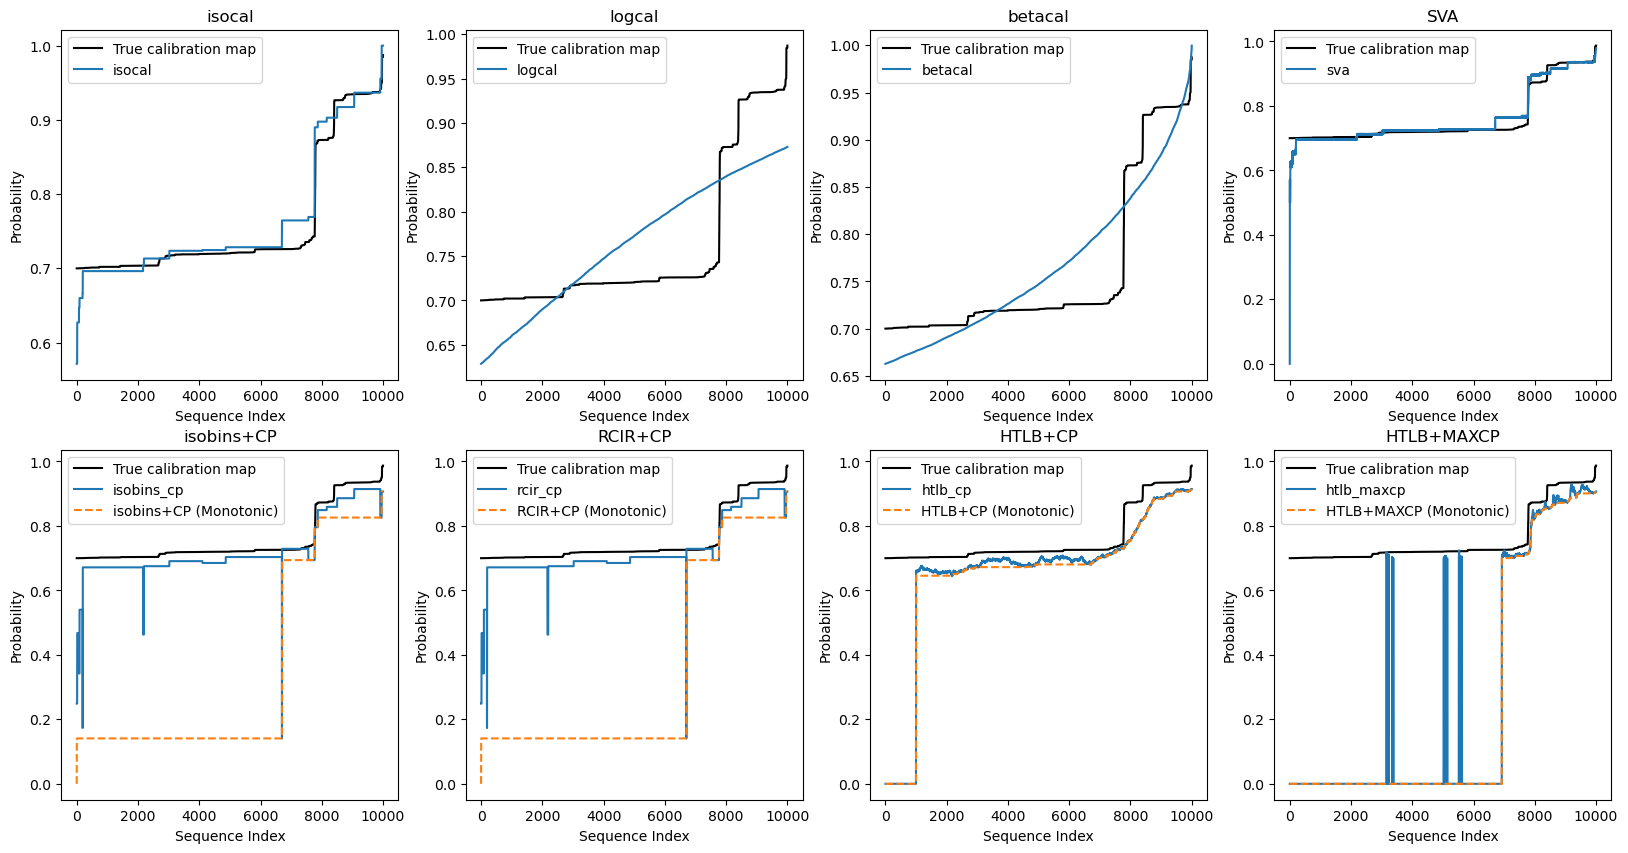

In [22]:
# plot all the calibration maps in one figure


keys = list(calibration_maps.keys())
values = list(calibration_maps.values())
method_names = ['True calibration map', 'isocal', 'logcal', 'betacal', 'SVA', 'isobins+CP', 'RCIR+CP', 'HTLB+CP', 'HTLB+MAXCP']


ax, fig = plt.subplots(2, 4, figsize=(20, 10))

counter = 1
for i in range(2):
    for j in range(4):
        key = keys[counter]
        value = values[counter]
        fig[i, j].plot(values[0], label='True calibration map', color='black')
        fig[i, j].plot(value, label=key)
        if key in monotonic_calibration_maps:
            fig[i, j].plot(monotonic_calibration_maps[key], label=method_names[counter] + ' (Monotonic)', linestyle='--')
        fig[i, j].set_title(method_names[counter])
        fig[i, j].set_xlabel('Sequence Index')
        fig[i, j].set_ylabel('Probability')
        fig[i, j].legend()
        counter += 1


plt.show()